# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model.
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [2]:
%pip install hf_xet
%pip install yfinance

In [3]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import math
import matplotlib.pyplot as plt
import yfinance as yf
from tqdm import tqdm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [5]:
df_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MNA/Fintech e innovación digital en finanzas (Gpo 10)/df_news.csv')

df_news.drop_duplicates('SUMMARY', inplace=True)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


In [6]:
df_meta = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MNA/Fintech e innovación digital en finanzas (Gpo 10)/df_metadata.csv')
display(df_meta)

,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services
...,...,...,...,...
485,XEL,Xcel Energy Inc.,Utilities,Utilities - Regulated Electric
486,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery
487,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants
488,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


In [9]:
# CODE HERE
# Use as many coding cells as you need

# %%
MODEL_NAME = 'cross-encoder/nli-deberta-v3-base'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device).eval()

id2label = model.config.id2label
label2id = {v:k for k, v in id2label.items()}
# Most NLI models use: 0=CONTRADICTION, 1=NEUTRAL, 2=ENTAILMENT
entail_idx = label2id.get('ENTAILMENT', 2)

# Texts to score
texts = df_news['TITLE'].fillna('').astype(str).tolist()

hyp_pos = "This headline is positive."
hyp_neg = "This headline is negative."

batch_size = 32
pos_probs = []
neg_probs = []

softmax = torch.nn.Softmax(dim=1)

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]

    # Positive hypothesis
    enc_pos = tokenizer(batch, [hyp_pos]*len(batch), padding=True, truncation=True, return_tensors='pt', max_length=256)
    enc_pos = {k:v.to(device) for k,v in enc_pos.items()}
    with torch.no_grad():
        out_pos = model(**enc_pos).logits
        prob_pos = softmax(out_pos)[:, entail_idx].detach().cpu().numpy()
    pos_probs.extend(prob_pos.tolist())

    # Negative hypothesis
    enc_neg = tokenizer(batch, [hyp_neg]*len(batch), padding=True, truncation=True, return_tensors='pt', max_length=256)
    enc_neg = {k:v.to(device) for k,v in enc_neg.items()}
    with torch.no_grad():
        out_neg = model(**enc_neg).logits
        prob_neg = softmax(out_neg)[:, entail_idx].detach().cpu().numpy()
    neg_probs.extend(prob_neg.tolist())

# Attach to dataframe
df_news = df_news.copy()
df_news['POSITIVE_PROB'] = pos_probs
df_news['NEGATIVE_PROB'] = neg_probs
# Centered sentiment signal
df_news['SENTIMENT'] = df_news['POSITIVE_PROB'] - df_news['NEGATIVE_PROB']
df_news['SENTIMENT_NORM'] = (df_news['POSITIVE_PROB'] - df_news['NEGATIVE_PROB']) / (df_news['POSITIVE_PROB'] + df_news['NEGATIVE_PROB'] + 1e-6)
df_news['NEUTRAL_PROB'] = 1 - df_news[['POSITIVE_PROB','NEGATIVE_PROB']].max(axis=1)


# Parse publication date to date (UTC-agnostic daily bucket)
df_news['DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date

print(df_news[['TICKER','TITLE','POSITIVE_PROB','NEGATIVE_PROB','SENTIMENT']].head(5))

100%|██████████| 125/125 [20:30<00:00,  9.84s/it]

  TICKER                                              TITLE  POSITIVE_PROB  \
0    MMM  2 Dow Jones Stocks with Promising Prospects an...       0.071958   
1    MMM               3 S&P 500 Stocks Skating on Thin Ice       0.975785   
2    MMM  3M Rises 15.8% YTD: Should You Buy the Stock N...       0.931809   
3    MMM  Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...       0.999741   
4    MMM  3 Cash-Producing Stocks with Questionable Fund...       0.003325   

   NEGATIVE_PROB  SENTIMENT  
0       0.003989   0.067969  
1       0.989665  -0.013880  
2       0.001223   0.930585  
3       0.997277   0.002464  
4       0.987304  -0.983979  


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

/tmp/ipython-input-1663344065.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(
[*********************100%***********************]  487 of 487 completed


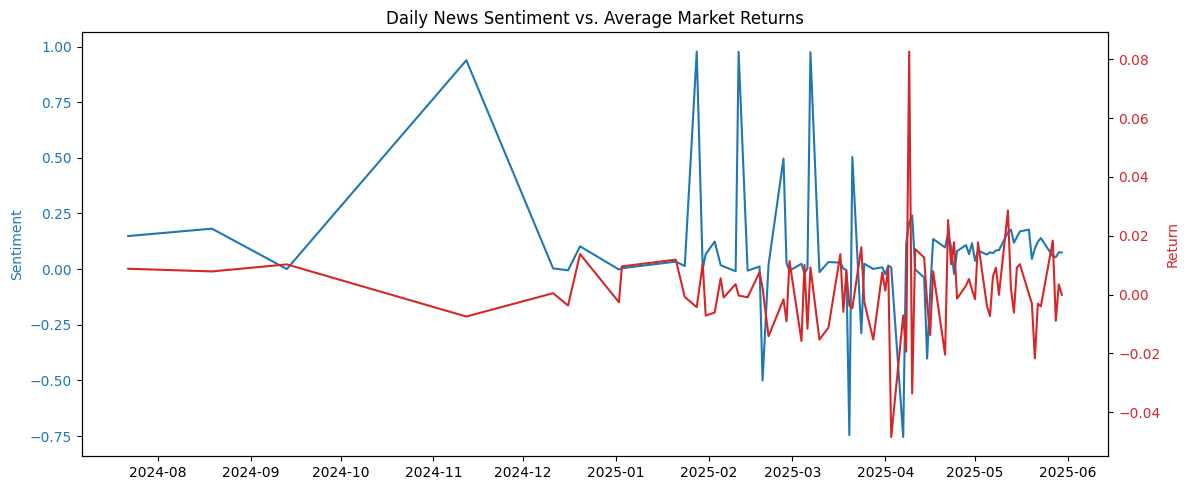

In [13]:
# CODE HERE
# Use as many coding cells as you need


# --- 1. Daily sentiment ---
df_news['DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
daily_sentiment = df_news.groupby('DATE')['SENTIMENT'].mean()

# --- 2. Download stock prices ---
tickers = df_news['TICKER'].unique().tolist()
prices = yf.download(
    tickers,
    start=daily_sentiment.index.min(),
    end=daily_sentiment.index.max()
)

# --- 3. Select closing prices ---
if 'Adj Close' in prices.columns:  # if yf.download includes 'Adj Close'
    close_prices = prices['Adj Close']
else:
    close_prices = prices['Close']

# --- 4. Compute daily returns ---
daily_returns = close_prices.pct_change().mean(axis=1)

# --- 5. Combine sentiment and returns ---
combined = pd.DataFrame({
    'SENTIMENT': daily_sentiment,
    'RETURN': daily_returns
}).dropna()

# --- 6. Plot dual-axis chart ---
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(combined.index, combined['SENTIMENT'], color='tab:blue', label='Sentiment')
ax1.set_ylabel('Sentiment', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(combined.index, combined['RETURN'], color='tab:red', label='Return')
ax2.set_ylabel('Return', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Daily News Sentiment vs. Average Market Returns')
fig.tight_layout()
plt.show()


## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


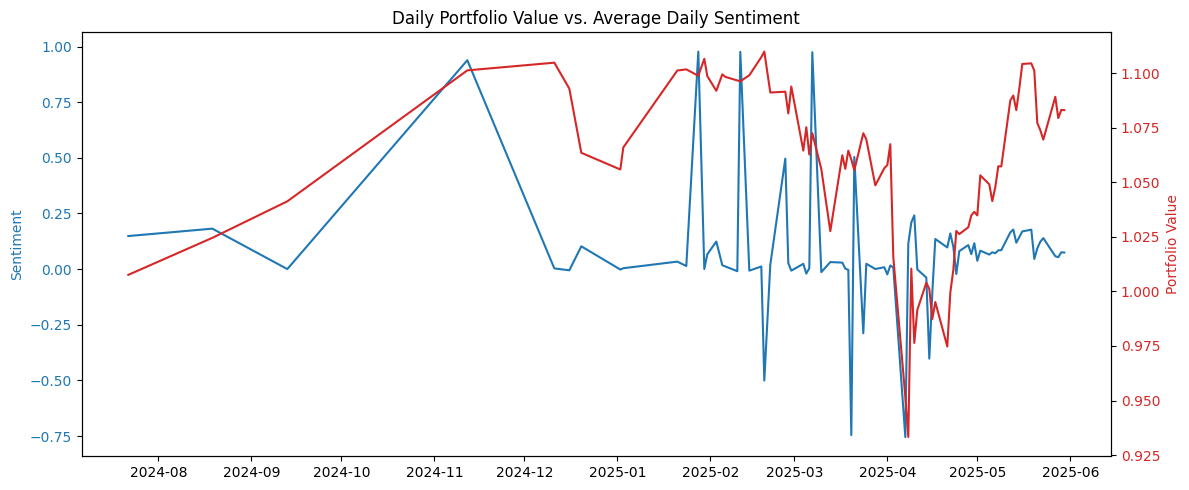

In [16]:
# CODE HERE
# Use as many coding cells as you need

# --- 1. Calculate the average daily return across all tickers ---
daily_returns = close_prices.pct_change().mean(axis=1)

# --- 2. Simulate cumulative portfolio value ---
initial_value = 1.0
portfolio_value = (1 + daily_returns).cumprod() * initial_value

# --- 3. Average daily sentiment ---
daily_avg_sentiment = df_news.groupby('DATE')['SENTIMENT'].mean()

# Align dates between portfolio and sentiment
combined_portfolio = pd.DataFrame({
    'PORTFOLIO_VALUE': portfolio_value,
    'SENTIMENT': daily_avg_sentiment
}).dropna()

# --- 4. Plot portfolio vs sentiment ---
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(combined_portfolio.index, combined_portfolio['SENTIMENT'], color='tab:blue', label='Average Daily Sentiment')
ax1.set_ylabel('Sentiment', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(combined_portfolio.index, combined_portfolio['PORTFOLIO_VALUE'], color='tab:red', label='Portfolio Value')
ax2.set_ylabel('Portfolio Value', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Daily Portfolio Value vs. Average Daily Sentiment')
fig.tight_layout()
plt.show()

## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [17]:
# CODE HERE
# Use as many coding cells as you need

# --- 1. Merge news with metadata to get sector info ---
df_news_meta = df_news.merge(df_meta[['TICKER','SECTOR']], on='TICKER', how='left')

# --- 2. Convert publication date to datetime and extract month ---
df_news_meta['DATE'] = pd.to_datetime(df_news_meta['PUBLICATION_DATE'])
df_news_meta['MONTH'] = df_news_meta['DATE'].dt.to_period('M')  # Monthly period

# --- 3. Compute monthly average sentiment per sector ---
sector_monthly_sentiment = df_news_meta.groupby(['SECTOR','MONTH'])['SENTIMENT'].mean().reset_index()

# --- 4. Count number of headlines per month (optional) ---
sector_monthly_count = df_news_meta.groupby(['SECTOR','MONTH']).size().reset_index(name='HEADLINE_COUNT')

# --- 5. Compute monthly stock returns per ticker ---
monthly_prices = close_prices.resample('M').last()  # Last price of each month
monthly_returns = monthly_prices.pct_change()  # Monthly returns

# --- 6. Map tickers to sectors ---
ticker_sector_map = df_meta.set_index('TICKER')['SECTOR'].to_dict()
monthly_returns_sector = monthly_returns.copy()
monthly_returns_sector.columns = [ticker_sector_map.get(ticker, 'Unknown') for ticker in monthly_returns.columns]

# --- 7. Compute average monthly return per sector ---
sector_monthly_returns = monthly_returns_sector.groupby(axis=1, level=0).mean()

# --- 8. Extract May sentiment and returns ---
may_period = pd.Period('2025-05', freq='M')
may_sentiment = sector_monthly_sentiment[sector_monthly_sentiment['MONTH'] == may_period].set_index('SECTOR')['SENTIMENT']
may_returns = sector_monthly_returns.loc[monthly_returns.index.month==5].mean()  # average across May

# --- 9. Build comparison table ---
sector_comparison = pd.DataFrame({
    'SECTOR': may_sentiment.index,
    'SENTIMENT_MAY': may_sentiment.values,
    'RETURN_MAY': may_returns.reindex(may_sentiment.index).values
})

print("Sector-level Sentiment vs May Returns:")
print(sector_comparison)

# --- 10. Compute correlation ---
correlation = sector_comparison['SENTIMENT_MAY'].corr(sector_comparison['RETURN_MAY'])
print(f"\nCorrelation between May sentiment and May returns: {correlation:.4f}")


Sector-level Sentiment vs May Returns:
                    SECTOR  SENTIMENT_MAY  RETURN_MAY
0          Basic Materials       0.179615    0.029613
1   Communication Services       0.040514    0.041527
2        Consumer Cyclical       0.064924    0.056382
3       Consumer Defensive       0.052669    0.000008
4                   Energy       0.099664    0.029434
5       Financial Services       0.094723    0.061068
6               Healthcare       0.140835    0.000100
7              Industrials       0.046358    0.073894
8              Real Estate       0.127236    0.010360
9               Technology       0.117054    0.075285
10               Utilities       0.095863    0.032967

Correlation between May sentiment and May returns: -0.2920


/tmp/ipython-input-2007967831.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_news_meta['MONTH'] = df_news_meta['DATE'].dt.to_period('M')  # Monthly period
/tmp/ipython-input-2007967831.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = close_prices.resample('M').last()  # Last price of each month
/tmp/ipython-input-2007967831.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sector_monthly_returns = monthly_returns_sector.groupby(axis=1, level=0).mean()


### **Question 1.** Which sectors *looked* good in the news? How did they perform?


**Sectors with highest May sentiment**:

* Basic Materials: 0.1796
* Healthcare: 0.1408
* Real Estate: 0.1272
* Technology: 0.1171

**Performance**:

* Basic Materials: +2.96% → moderately positive returns.
* Healthcare: +0.01% → almost flat performance.
* Real Estate: +1.04% → slightly positive.
* Technology: +7.53% → strong performance.

**Observations**: Some sectors with very positive news (Healthcare, Real Estate) did not see strong returns, while Technology performed well and aligned with positive sentiment.



### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


**Industrials**: sentiment 0.0464, return +7.39% → low sentiment but strong returns.

**Consumer Cyclical**: sentiment 0.0649, return +5.64% → moderate sentiment, solid returns.

**Financial Services**: sentiment 0.0947, return +6.11% → moderate sentiment, good returns.

**Observation**: Some sectors like Industrials performed well despite relatively neutral coverage, showing that sentiment doesn’t always predict performance.

### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

No. Correlation between May sentiment and May returns is -0.292, indicating weak and negative relationship.

Positive news does not always lead to strong performance (e.g., Healthcare, Real Estate).

Market returns are influenced by many factors beyond sentiment (macroeconomics, earnings, interest rates, etc.).

Sentiment could be one signal among many, but relying on it alone is risky.

### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

* **Longer historical period**: analyze sentiment and returns over multiple months or years.

* **Backtesting a portfolio**: simulate trading rules based on sentiment signals (e.g., invest in top 20% most positive sectors).

* **Cross-validation**: test on out-of-sample data to avoid overfitting.

* **Control for other factors**: include sector beta, volatility, earnings reports, and macroeconomic data.

* **Lag analysis**: check if sentiment predicts future returns (1–5 days, 1 month).

* **Statistical significance**: use correlation tests, regression models, or machine learning to quantify predictive power.